# 3.2 Velocity-based motion model

In the remainder of this chapter we will describe two probabilistic motion models for planar movement: the **velocity motion model** and the **odometry motion model**, the former being the main topic of this section. Remember that when a movement command is given to a robot, there are different factors that affect such movement (*e.g.* wheel slippage, unequal floor, inaccurate calibration, etc.), adding uncertainty to the actual move done. This results in a need for characterizing the robot motion in *probabilistic terms*, that is:

$$p(x_t | u_t, x_{t-1})$$

being:
- $x_t$ the robot pose at time instant $t$,
- $u_t$ the motion command (also called control action) at $t$, and
- $x_{t-1}$ the robot pose at the previous time instant $t-1$.

So basically this probability models the probability distribution over robot poses when executing the motion command $u_t$, having the robot the previous pose $x_{t-1}$. In other words, we are considering a function $g(\cdot)$ that performs $x_t=g(x_{t-1},u_t)$ and outputs $x_t \sim p(x_t | u_t, x_{t-1})$. $\\[10pt]$

<figure style="text-align:center">
  <img src="images/fig3-2-probatilistic_robot_motion.png" alt="" width="400px">
  <figcaption>Fig. 1: Inputs and outputs of a probabilistic motion model.</figcaption>
</figure>


Different definitions for the $g(\cdot)$ function lead to different probabilistic motion models, like the velocity motion model explored here.

## 3.2.1 The model

The *velocity motion model* is mainly used for motion planning, where the details of the robot's movement are of importance and odometry information is not available (*e.g.* no wheel encoders are available).

This motion model is characterized by the use of two velocities to control the robot's movement: **linear velocity** $v$ and **angular velocity** $w$. Therefore, during the following sections, the movement commands will be of the form: 

$$u_t = \begin{bmatrix} v_t \\ w_t \end{bmatrix}, \, \, \, u_t \sim N(\overline{u},\Sigma_{u_t})$$

The velocity motion model defines the function $g(\cdot)$ as:

$$g(x_{t-1},u_t)=x_{t-1} \oplus \Delta x_t, \, \, \,
x_{t-1}\sim N (\overline{x}_{t-1},\Sigma_{x_{t-1}})$$

being $\Delta_{x_t}=[\Delta_{x_t}, \Delta_{y_t}, \Delta_{\theta_t}]$ (assuming w and v constant):
- $\Delta x_t = \frac{v}{w} \sin(w\Delta t)$
- $\Delta y_t = \frac{v}{w} [1-\cos(w\Delta t)]$
- $\Delta \theta_t = w\Delta t$

Note that $g(x_{t-1},u_t)=x_{t-1} \oplus \Delta x_t$ **is not a linear operation!**

In this way, this motion model is characterized by the following equations, depending on the value of the angular velocity $w$ (note that a division by zero would appear in the first case with $w=0$):


- If $w \neq 0$:

    $$
        \begin{bmatrix}
        x_t \\
        y_t \\
        \theta_t \\ 
        \end{bmatrix} 
        = 
        \begin{bmatrix}
        x_{t-1} \\
        y_{t-1} \\
        \theta_{t-1} \\ 
        \end{bmatrix} 
        +
        \begin{bmatrix}
            -R \sin \theta_{t-1} + R \sin(\theta_{t-1} + \Delta \theta) \\ 
            R \cos \theta_{t-1} - R \cos(\theta_{t-1} + \Delta \theta)\\
            \Delta \theta
        \end{bmatrix}
    $$

- If $w = 0$:

    $$
       \begin{bmatrix}
        x_t \\
        y_t \\
        \theta_t \\ 
        \end{bmatrix} 
        = 
        \begin{bmatrix}
        x_{t-1} \\
        y_{t-1} \\
        \theta_{t-1} \\ 
        \end{bmatrix} 
        + v \cdot \Delta t
        \begin{bmatrix}
            \cos \theta_{t-1} \\ \sin \theta_{t-1} \\ 0
        \end{bmatrix}
    $$

with: 

- $v = w \cdot R \ $   *(R is also called the curvature radius)*
- $\Delta \theta = w \cdot  \Delta t$



In [1]:
%matplotlib widget

# IMPORTS
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time


import sys
sys.path.append("..")
from utils.DrawRobot import DrawRobot
from utils.PlotEllipse import PlotEllipse

### **<span style="color:green"><b><i>ASSIGNMENT 1: The model in action</i></b></span>**

Modify the following `next_pose()` function, used in the `VelocityRobot` class below, which computes the next pose $x_t$ of a robot given:
- its previous pose $x_{t-1}$, 
- the velocity movement command $u=[v,w]^T$, and
- a lapse of time $\Delta t$. 

Concretly you have to complete the if-else statement that takes into account when the robot moves in an straight line so $w = 0$. 
*Note: you don't have to modify the `None` in the function header nor in the `if cov is not None:` condition.*

Remark that at this point **we are not taking into account uncertainty in the system**: neither from the initial pose ($\Sigma_{x_{t-1}}$) nor the movement $(v, w)$ ($\Sigma_{u_{t}}$).

**Example**

<figure style="text-align:center">
  <img src="images/fig3-2-1.png" alt="">
  <figcaption>Fig. 2: Route of our robot.</figcaption>
</figure>

In [12]:
def next_pose(x, u, dt, cov=None):
    ''' This function takes pose x and transform it according to the motion u=[v,w]'
        applying the differential drive model.

        Args:
            x: current pose
            u: differential command as a vector [v, w]'
            dt: Time interval in which the movement occurs
            cov: covariance of our movement. If not None, then add gaussian noise
    '''
    theta = x[2]
    if cov is not None:
        u += np.sqrt(cov) @ random.randn(2, 1)
        #u = np.random.multivariate_normal(u.flatten(),cov)

    if u[1] == 0: #linear motion w=0
        next_x = x + dt * u[0] * np.vstack([np.cos(x[2]),
                                            np.sin(x[2]),
                                            0])
    else: #Non-linear motion w=!0
        R = u[0]/u[1] #v/w=r is the curvature radius
        dtheta = u[1]*dt
        next_x = x + np.vstack([-R*np.sin(theta) + R*np.sin(theta + dtheta),
                                R*np.cos(theta) - R*np.cos(theta + dtheta),
                                dtheta])

    return next_x

In [13]:
class VelocityRobot(object):
    """ Mobile robot implementation that uses velocity commands.
    
        Attr:
            pose: expected pose of the robot in the real world (without taking account noise)
            dt: Duration of each step in seconds
    """    
    def __init__(self, mean, dt):
        self.pose = mean
        self.dt = dt
        
    def step(self, u):
        self.pose = next_pose(self.pose, u, self.dt)
        
    def draw(self, fig, ax):
        DrawRobot(fig, ax, self.pose)

**Test the movement of your robot** using the demo below.

In [14]:
def main(robot, nSteps):
          
    v = 1 # Linear Velocity 
    l = 0.5 #Half the width of the robot
        
    # MATPLOTLIB
    fig, ax = plt.subplots()
    plt.ion()
    fig.canvas.draw()
    plt.xlim((-2, 20))
    plt.ylim((-2, 30))
    plt.fill([7.5, 7.5, 16, 16, 20, 20],[-2, 7.5, 7.5, 20, 20, -2],
             facecolor='lightgray', edgecolor='gray', linewidth=3)
    plt.fill([-3, 0, 0, 7.5, 7.5, -3],[5, 5, 17.5, 17.5, 32, 32],
             facecolor='lightgray', edgecolor='gray', linewidth=3)
    
    plt.grid()
        
    # MAIN LOOP
    for k in range(1, nSteps + 1):
        #control is a wiggle with constant linear velocity
        u = np.vstack((v, np.pi / 10 * np.sin(4 * np.pi * k/nSteps)))
        
        robot.step(u)   
        
        #draw occasionally
        if (k-1)%20 == 0:
            robot.draw(fig, ax)
            clear_output(wait=True)
            display(fig)        
            time.sleep(0.1)
            
    plt.close()


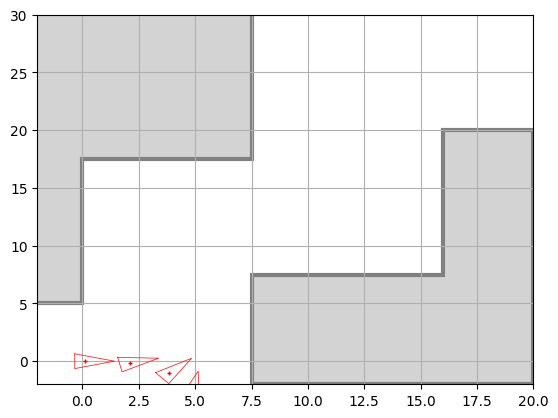

In [15]:
# RUN 
dT = 0.1 # time steps size
pose = np.vstack([0., 0., 0.])

robot = VelocityRobot(pose, dT)
main(robot, nSteps=400)

## 3.2.2 Propagating uncertainty

In the previous section we introduced how to compute the robot pose $x$ at time instant $t$ by applying a control action $u_t$. However, as we know, this process has different sources of uncertainty that need to be modeled someway. 

To deal with this we will consider two Gaussian distributions:
- the **robot pose** modeled as $x_t \sim(\overline{x}_t, \Sigma_{x_t})$ at time $t$.
Similarly, for the **previous pose** at $t-1$ we have $x_{t-1} \sim(\overline{x}_{t-1}, \Sigma_{x_{t-1}})$,
- and the **movement command** as $u_t\sim(\overline{u}_t, \Sigma_{u_t})$, being applied during an interval of time $\Delta t$.

In this way, after a motion command we can retrieve the probability distribution $x_t$ modeling the new robot pose as:

- **Mean:**
$$\overline{x}_t = \overline{x}_{t-1} \oplus \overline{u}_t = g(\overline{x}_{t-1}, \overline{u}_t)$$

- **Covariance:**
$$\Sigma_{x_t} =  \frac{\partial g}{\partial x_{t-1}} \cdot \Sigma_{x_{t-1}} \cdot {\frac{\partial g}{\partial x_{t-1}}}^T + \frac{\partial g}{\partial u_{t}} \cdot \Sigma_{u_t} \cdot {\frac{\partial g}{\partial u_{t}}}^T \\[10pt]$$
where $\partial g / \partial x_{t-1}$ and $\partial g / \partial u_{t}$ are the jacobians of our motion model evaluated at the previous pose $x_{t-1}$ and the current command $u_t$, and the covariance matrix of this movement ($\Sigma_{u_t}$) is defined as seen below. Typically, it is constant during robot motion:$\\[10pt]$
$$ 
    \Sigma_{u_t} = \begin{bmatrix}
            \sigma_v^2 & 0 \\
            0 &  \sigma_w^2
        \end{bmatrix}
$$

## <span style="color:green">OPTIONAL</span>

<span style="color:green">Write a Markdown cell containing the Jacobians ecuations aforementioned.</span>

<span style="color:green">***END OF OPTIONAL PART***</span>

### **<span style="color:green"><b><i>ASSIGNMENT 2: Adding uncertainty</i></b></span>**

Now we will include uncertainty to the previous assignment, changing the behavior of the robot class `VelocityRobot()` you have implemented.

In contrast to the noisy robot `NoisyRobot()` in notebook 3.1, we will use the equations of the velocity motion model and their respective Jacobians to keep track of how confident we are of the robot's pose (i.e. the robot's pose $x_t$ now is also a gaussian distribution).

Consider the following:
- the expected robot pose $\overline{x}_t$ is stored in `self.pose`.
- the covariance matrix of the robot pose $\Sigma_{x_t}$ is named `P_t` in the code,
- the covariance matrix of the robot motion $\Sigma_{u_t}$ is `Q`, and
- the jacobians of our motion model $\partial g / \partial x_{t-1}$ and $\partial g / \partial u_{t}$ are  `JacF_x` and `JacF_u`.

**First** Complete the following code calculating the covariance matrix $\Sigma_{x_t}$ (`P_t`). That is, you have to:
- Implement the jacobians `JacF_x` and `JacF_u`, which depend on the angular velocity $w$, and
- Compute the covariance matrix `P_t`using such jacobians, the current covariance of the pose `P`, and the covariance of the motion `Q`.

In [ ]:
def next_covariance(x, P, Q, u, dt):
    ''' Compute the covariance of a robot following the velocity motion model

        Args:
            x: current pose (before movement)
            u: differential command as a vector [v, w]''
            dt: Time interval in which the movement occurs
            P: current covariance of the pose
            Q: covariance of our movement.
    '''
    # Aliases
    v = u[0, 0]
    w = u[1, 0]

    sx, cx = np.sin(x[2, 0]), np.cos(x[2, 0]) #sin and cos for the previous robot heading
    si, ci = np.sin(u[1, 0]*dt), np.cos(u[1, 0]*dt) #sin and cos for the heading increment
    R = u[0, 0]/u[1, 0] #v/w Curvature radius

    if u[1, 0] == 0:  #linear motion w=0 --> R = infinite
        #TODO JACOBIAN HERE
        JacF_x = np.array([
            None,
            None,
            None
        ])
        JacF_u = np.array([
            None,
            None,
            None
        ])
    else: #Non-linear motion w=!0
        # TODO JACOBIAN HERE
        JacF_x = np.array([
            None,
            None,
            None
        ])

        JacF_u = (
            np.array([
                None,
                None,
                None
            ])@
            np.array([
                [1/w, -v/w**2],
                [0, dt]
            ])
        )
    #prediction steps
    Pt = ( None @ None @ None ) + ( None @ None @ None )
    
    return Pt

**Then**, complete the methods:

  - `step()` to get the true robot pose (ground-truth) using the $Q$ matrix (recall the `next_pose()` function you defined before and its fourth input argument), 
  - and the `draw()` one to plot an ellipse representing the uncertainty about the robot pose centered at the expected robot pose (`self.pose`) as well as marks representing the ground truth poses.
  

 
**Example**
 
<figure style="text-align:center">
  <img src="images/fig3-2-2.png" alt="">
  <figcaption>Fig. 3: Movement of a robot using velocity commands. <br/> Representing the expected pose (in red), the true pose (as dots) <br/> and the confidence ellipse.</figcaption>
</figure>

In [ ]:
class NoisyVelocityRobot(VelocityRobot):
    """ Mobile robot implementation that uses velocity commands.
       
        Attr:
            [...]: Inherited from VelocityRobot
            true_pose: expected pose of the robot in the real world (noisy)
            cov_pose: Covariance of the pose at each step
            cov_move: Covariance of each movement. It is a constant

    """
    
    def __init__(self, mean, cov_pose, cov_move, dt):
        super().__init__(mean, dt)
        self.true_pose = mean
        self.cov_pose = cov_pose
        self.cov_move = cov_move
        
    def step(self, u):
        self.cov_pose = next_covariance(None, None, None, None, None)
        
        super().step(u)
        self.true_pose = next_pose(None, None, None, cov=None)
        
    def draw(self, fig, ax):
        super().draw(fig, ax)
        el = PlotEllipse(fig, ax, None, None)
        ax.plot(None, None, 'o', color=el[0].get_color())

Now, **try your implementation!**

In [ ]:
# RUN
dT = 0.1 # time steps size

SigmaV = 0.2 #Standard deviation of the linear velocity. 
SigmaW = 0.1 #Standard deviation of the angular velocity
nSteps = 400 #Number of motions

P = np.diag([0.2, 0.4, 0.]) #pose covariance matrix 3x3
Q = np.diag([SigmaV**2, SigmaW**2]) #motion covariance matrix 2x2

robot = NoisyVelocityRobot(np.vstack([0., 0., 0.]), P, Q, dT)
main(robot, nSteps=nSteps)

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Now that you have some experience with robot motion and the velocity motion model, **answer the following questions**:

- Why do we need to consider two different cases when applying the $g(\cdot)$ function, that is, calculating the new robot pose?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>

- How many parameters compound the motion command $u_t$ in this model?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- Why do we need to use Jacobians to propagate the uncertainty about the robot pose $x_t$?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>

- What happens if you modify the covariance matrix $\Sigma_{u_t}$ modeling the uncertainty in the motion command $u_t$? Try different values and discuss the results. 

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>